# Policy Iteration on Grid World
This notebook shows how to use policy iteration on the gridworld environment

In [1]:
# Set relative path to parent directory
import sys, os
sys.path.insert(0, os.path.abspath('..'))

In [2]:
# Import and set up environment
%matplotlib inline
from environments.gridWorld import gridWorld
env = gridWorld("../environments/gridworlds/tiny.json")

## Policy evaluation algorithms

For policy evaluation we wish to solve the equation
$$ V^{\pi}(s) = R(s, \pi(s) + \gamma \sum_{s \in S }P(s' | s, \pi(s)) V^{\pi}(s')$$

This can be done in two ways, eiter by iteratively improving an estimate of $ V^{\pi}(s) $ wich we call $ V^{\pi}_{i}(s) $  by using the old estimate of the value function $ V^{\pi}_{i-1}(s) $ until they converge ($ | V^{\pi}_{i}(s) - V^{\pi}_{i-1}(s)| < \epsilon$) this gives the algorithem:

Evaluate:
$$ V^{\pi}_{i}(s) = R(s, \pi(s) + \gamma \sum_{s \in S }P(s' | s, \pi(s)) V^{\pi}_{i - 1}(s')$$

until: 
$$ | V^{\pi}_{i}(s) - V^{\pi}_{i-1}(s)| < \epsilon$$

The other method is to directly solve the linear equation by noticing that the equation can be formulated as the following linear system:

$$
\begin{bmatrix}
    \gamma P(s_1 | s_1, \pi(s_1) - 1 & \gamma P(s_2 | s_1, \pi(s_1) & \gamma P(s_3 | s_1, \pi(s_1) & \dots  & \gamma P(s_n | s_1, \pi(s_1) \\
    \gamma P(s_1 | s_2, \pi(s_2) & \gamma P(s_2 | s_2, \pi(s_2) - 1 & \gamma P(s_3 | s_2, \pi(s_2) & \dots  & \gamma P(s_n | s_2, \pi(s_2) \\
    \vdots & \vdots & \vdots & \ddots & \vdots \\
    \gamma P(s_1 | s_n, \pi(s_n) & \gamma P(s_2 | s_n, \pi(s_n) & \gamma P(s_3 | s_n, \pi(s_n) & \dots  & \gamma P(s_n | s_n, \pi(s_n) - 1
\end{bmatrix}
\begin{bmatrix}
    V^{\pi}(s_1) \\
    V^{\pi}(s_2) \\
    \vdots \\
    V^{\pi}(s_n)
\end{bmatrix}
=
\begin{bmatrix}
    - R(s_1, \pi(s_1) \\
    - R(s_2, \pi(s_2)\\
    \vdots \\
    - R(s_n, \pi(s_n)
\end{bmatrix}
$$
and solving for the value functions directly

In [3]:
import copy
import numpy as np


# Evaluate the policy by iterativly improving it such that it converges
def policy_evaluation_itrative(PI, mdp, gamma, V = dict(), epsilon = 1e-3):
    # Initialize values to zero
    if not V:
        for s in env.states():
            V.update({s: 0.0})
    while(True):
        V_prev = copy.deepcopy(V)
        delta = 0
        for s in mdp.states():
            lst = []
            value_sum = 0
            for s_next in mdp.states():
                value_sum += mdp.transition_probability(s_next, s, PI[s])*V[s_next]
            V[s] = mdp.reward(s) + gamma*value_sum
            if np.abs(V[s] - V_prev[s]) > delta:
                delta = np.abs(V[s] - V_prev[s])
        if delta < epsilon*(1 - gamma)/gamma or (gamma == 1 and delta  < epsilon):
            return V
        
# Evaluate the policy by setting up and solving the linear equations
def policy_evaluation_linalg(PI, mdp, gamma, V = dict()):
    states = list(mdp.states())
    size = len(states)

    A = np.zeros((size, size))
    b = np.zeros((size))

    for row in range(size):
        for col in range(size):
            prob = mdp.transition_probability(states[col], states[row], PI[states[row]])
            A[row, col] = gamma*prob - (1 if row == col else 0)
            
        b[row] = -mdp.reward(states[row])
        
    v = np.linalg.solve(A, b)
    for i, s in enumerate(states):
        V.update({s : v[i]})
    return V

## Policy iteration
The policy iteration algorithem is as follows

In [4]:
import numpy as np
import copy

def policy_iteration(mdp, gamma, iterative_evaluation = False):
    # Create an arbitrary policy PI and value function V
    PI = dict()
    V = dict()
    for s in env.states():
        PI.update({s : np.random.choice(env.actions())})
        V[s] = 0
        
    while(True):
        PI_prev = copy.deepcopy(PI)
        if iterative_evaluation:
            V = policy_evaluation_itrative(PI, mdp, gamma, V)
        else:
            V = policy_evaluation_linalg(PI, mdp, gamma)
            
        unchanged = True
        
        for s in mdp.states():
            a_lst = []
            v_lst = []
            for a in mdp.actions(s):
                value_sum = 0
                for s_next in mdp.states():
                    value_sum += mdp.transition_probability(s_next, s, a)*V[s_next]
                v_lst.append(value_sum)
                a_lst.append(a)
            if len(a_lst) > 0:
                PI.update({s: a_lst[np.argmax(v_lst)]})
            if PI[s] != PI_prev[s]:
                unchanged = False
        if unchanged:
            return PI, V
                
    

## Run policy iteration and show results

In [5]:
PI, V= policy_iteration(env, 0.1)

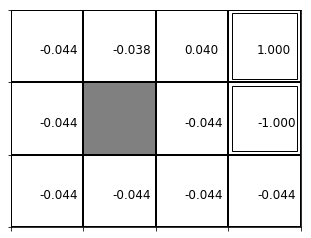

In [6]:
from matplotlib import pyplot as plt

def show_value_function(V):
    fig = env.render(show = False, show_state = False, show_reward = False)            
    for s in V.keys():
        fig.axes[0].annotate("{0:.3f}".format(V[s]), (s[1] - 0.1, s[0] + 0.1), size = 12)
    plt.show()

show_value_function(V)

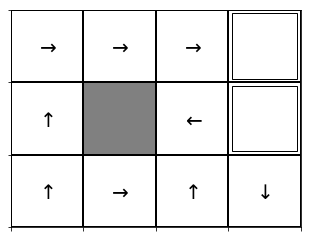

In [7]:
def show_policy(PI):
    fig = env.render(show = False, show_state = False, show_reward = False)
    action_map = {"U": "↑", "D": "↓", "L": "←", "R": "→"}
    for s in PI.keys():
        if env.terminal[s] == 0:
            fig.axes[0].annotate(action_map[PI[s]], (s[1] - 0.1, s[0] + 0.1), size = 20)
    plt.show()
    
show_policy(PI)

## Interactive policy iteration

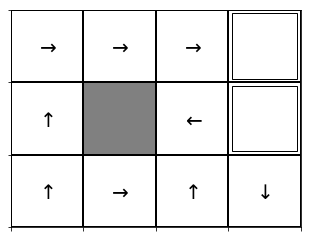

In [8]:
from ipywidgets import widgets

def f(gamma, probability, iterative):
    env.p = probability
    try:
        PI, V = policy_iteration(env, gamma, iterative)
        show_policy(PI)
        #show_value_function(V)
    except:
        pass
    

slider = widgets.interact(f, gamma=(0.0, 1.0, 0.1), probability = (0.0, 1.0, 0.1), iterative = False)